<a href="https://colab.research.google.com/github/hirotakaster/CoAP/blob/master/nns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faiss・NGTのインストール
FaissはGPUを利用する。ランタイムの設定でGPUを有効にしておく。

In [1]:
# Faiss のインストール
# !pip install faiss-cpu
!pip install faiss-gpu

     |████████████████████████████████| 90.1 MB 20 kB/s 


In [2]:
# NGTのインストール
!wget https://github.com/yahoojapan/NGT/archive/refs/tags/v1.13.8.tar.gz
!tar -zxvf v1.13.8.tar.gz
%cd NGT-1.13.8/
%mkdir build
%cd build
!apt install cmake
!cmake ..
!make
!make install
!pip3 install ngt

--2021-12-04 02:28:47--  https://github.com/yahoojapan/NGT/archive/refs/tags/v1.13.8.tar.gz
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/yahoojapan/NGT/tar.gz/refs/tags/v1.13.8 [following]
--2021-12-04 02:28:47--  https://codeload.github.com/yahoojapan/NGT/tar.gz/refs/tags/v1.13.8
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘v1.13.8.tar.gz’

v1.13.8.tar.gz          [    <=>             ]   1.99M  2.69MB/s    in 0.7s    

2021-12-04 02:28:48 (2.69 MB/s) - ‘v1.13.8.tar.gz’ saved [2088550]

NGT-1.13.8/
NGT-1.13.8/.gitignore
NGT-1.13.8/CMakeLists.txt
NGT-1.13.8/LICENSE
NGT-1.13.8/README-jp.md
NGT-1.13.8/README.jp
NGT-1.13.

In [3]:
# 画像表示用
import cv2
import matplotlib.pyplot as plt

def show_images_glob(images, figsize=(20,10), columns = 5):
  plt.figure(figsize=figsize)
  for i, f in enumerate(images):
      plt.subplot(len(images) / columns + 1, columns, i + 1)
      plt.imshow(cv2.cvtColor(cv2.imread(f), cv2.COLOR_BGR2RGB))

# 特徴量を取得するPytorchのモデル準備
・最後の結合層を除去して特徴量として利用する

In [15]:
import torch
import faiss
import matplotlib.pyplot as plt
import glob
import cv2
import os
from torchvision import transforms
from PIL import Image
from IPython.display import display

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', pretrained=True)
model.eval()

pointmodel = torch.nn.Sequential(*(list(model.children())[:-1]))
pointmodel.fc = torch.nn.Identity() 
pointmodel.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


# ■ Faiss用インデックスの作成

In [9]:
# Faiss Indexの作成
faissidx = faiss.IndexFlatL2(2048)
if torch.cuda.is_available():
    pointmodel.to('cuda')

files = glob.glob("/content/drive/MyDrive/imagesearch/images/*.jpeg")
for i, f in enumerate(files):
  print (str(i) + "," +f)
  input_image = Image.open(f)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = pointmodel(input_batch)
  n = output.to('cpu').detach().numpy().copy()
  faissidx.add(n.reshape(-1, 2048))

0,/content/drive/MyDrive/imagesearch/images/pexels-photo-10361015.jpeg
1,/content/drive/MyDrive/imagesearch/images/pexels-photo-10366895.jpeg
2,/content/drive/MyDrive/imagesearch/images/pexels-photo-10349991.jpeg
3,/content/drive/MyDrive/imagesearch/images/pexels-photo-10242969.jpeg
4,/content/drive/MyDrive/imagesearch/images/pexels-photo-9532325.jpeg
5,/content/drive/MyDrive/imagesearch/images/pexels-photo-8511641.jpeg
6,/content/drive/MyDrive/imagesearch/images/pexels-photo-8082560.jpeg
7,/content/drive/MyDrive/imagesearch/images/pexels-photo-7863536.jpeg
8,/content/drive/MyDrive/imagesearch/images/pexels-photo-7693184.jpeg
9,/content/drive/MyDrive/imagesearch/images/pexels-photo-7691691.jpeg
10,/content/drive/MyDrive/imagesearch/images/pexels-photo-7652306.jpeg
11,/content/drive/MyDrive/imagesearch/images/pexels-photo-7491214.jpeg
12,/content/drive/MyDrive/imagesearch/images/IMG_0338.jpeg
13,/content/drive/MyDrive/imagesearch/images/IMG_1131.jpeg
14,/content/drive/MyDrive/imagesearc

# Faissで画像探索

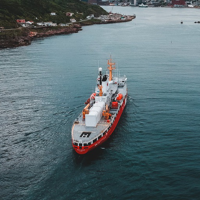

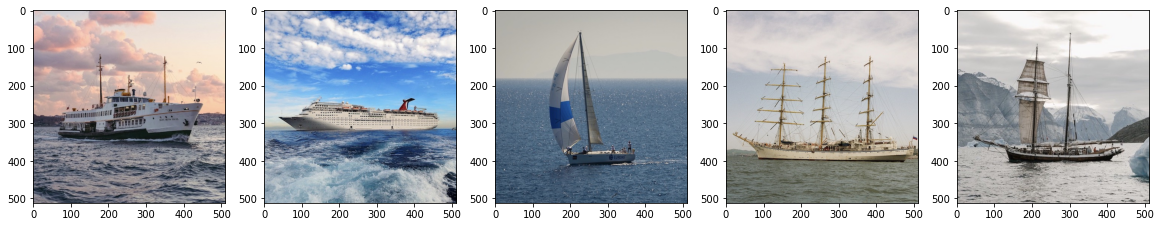

In [10]:
input_image = Image.open("/content/drive/MyDrive/imagesearch/test_images/6.jpeg")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
  output = pointmodel(input_batch)
n = output.to('cpu').detach().numpy().copy()

display(input_image.resize((200, 200)))

d, i = faissidx.search(n.reshape(-1, 2048), 5)
hitfiles = map(lambda f: files[f], i[0][::])
show_images_glob(list(hitfiles))

# NGTのインデックス作成

In [11]:
import ngtpy

ngtpy.create(path=b'index', dimension=2048, distance_type="L2")
index = ngtpy.Index(b'index')

if torch.cuda.is_available():
    pointmodel.to('cuda')

files = glob.glob("/content/drive/MyDrive/imagesearch/images/*.jpeg")
for i, f in enumerate(files):
  print (str(i) + "," +f)
  input_image = Image.open(f)
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0)

  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')

  with torch.no_grad():
    output = pointmodel(input_batch)
  n = output.to('cpu').detach().numpy().copy()
  index.insert(n.reshape(-1, 2048)[0]) 

index.build_index()
index.save()


0,/content/drive/MyDrive/imagesearch/images/pexels-photo-10361015.jpeg
1,/content/drive/MyDrive/imagesearch/images/pexels-photo-10366895.jpeg
2,/content/drive/MyDrive/imagesearch/images/pexels-photo-10349991.jpeg
3,/content/drive/MyDrive/imagesearch/images/pexels-photo-10242969.jpeg
4,/content/drive/MyDrive/imagesearch/images/pexels-photo-9532325.jpeg
5,/content/drive/MyDrive/imagesearch/images/pexels-photo-8511641.jpeg
6,/content/drive/MyDrive/imagesearch/images/pexels-photo-8082560.jpeg
7,/content/drive/MyDrive/imagesearch/images/pexels-photo-7863536.jpeg
8,/content/drive/MyDrive/imagesearch/images/pexels-photo-7693184.jpeg
9,/content/drive/MyDrive/imagesearch/images/pexels-photo-7691691.jpeg
10,/content/drive/MyDrive/imagesearch/images/pexels-photo-7652306.jpeg
11,/content/drive/MyDrive/imagesearch/images/pexels-photo-7491214.jpeg
12,/content/drive/MyDrive/imagesearch/images/IMG_0338.jpeg
13,/content/drive/MyDrive/imagesearch/images/IMG_1131.jpeg
14,/content/drive/MyDrive/imagesearc

# NGTで画像探索

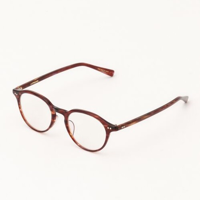

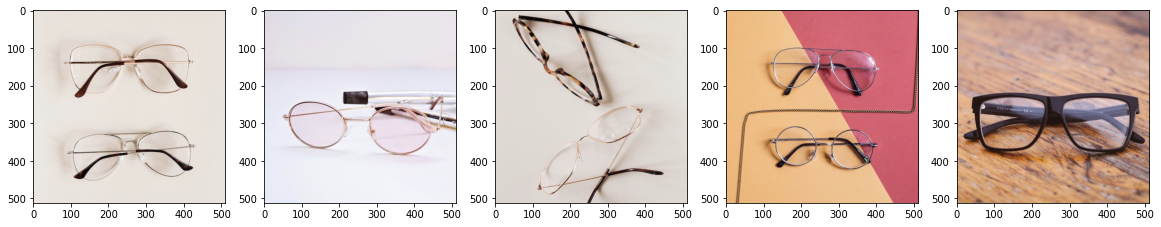

In [14]:
input_image = Image.open("/content/drive/MyDrive/imagesearch/test_images/7.jpeg")
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0)

if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')

with torch.no_grad():
  output = pointmodel(input_batch)
n = output.to('cpu').detach().numpy().copy()

display(input_image.resize((200, 200)))

r = index.search(n.reshape(-1, 2048)[0], 5)
hitfiles = map(lambda f: files[f], [b[0] for b in r])
show_images_glob(list(hitfiles))